### Import necessary libraries

In [1]:
import pandas as pd
import os
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

Data Cleaning
- Files present the header information in multiple rows, it is necessary to remove those rows
- Missing values in the data

In [2]:
files = [f for f in os.listdir('./datasets/') if os.path.isfile(os.path.join('./datasets/', f))]

# Create new CSV files without issues
for file in files:
    original_df = pd.read_csv('./datasets/' + file)

    for i in range(len(original_df)):
        if (original_df.loc[i, 'Order Date'] == 'Order Date'):
            original_df.drop(i, axis=0, inplace=True)

    # Dropping NA rows
    df = original_df.dropna()

    df.to_csv(file + ' - corrected version.csv', index=False)
         



Task #1 - Merging 12 months of sales data into a single file

In [5]:
files = [f for f in os.listdir('./datasets_fixed/') if os.path.isfile(os.path.join('./datasets_fixed/', f))]

df = pd.DataFrame()

for file in files:
    df = pd.concat([df, pd.read_csv('./datasets_fixed/' + file)])

df.to_csv('all_data.csv', index=False)

Task #2 - Read updated dataframe

In [6]:
all_data = pd.read_csv('./all_data.csv')
all_data.head()

# Transform 'Order Date' column into a datetime object
all_data['Order Date'] = pd.to_datetime(all_data['Order Date'])

Question #1 - What was the best month for sales? How much was earned that month?

- Adding additional columns

In [56]:
all_data['Month'] = all_data['Order Date'].dt.month_name()
all_data['Order Total'] = all_data['Price Each'] * all_data['Quantity Ordered']


- Discover the best month for sales

In [ ]:
sales_per_month = all_data.groupby('Month', as_index=False).agg({'Order Total': 'sum'}).sort_values(by='Order Total', ascending=False)

sales_plot = sales_per_month.plot(kind='bar', y='Order Total', x='Month', title='Sales per Month')
sales_plot.set_ylabel('Total Sales in Millons (USD)')
sales_plot.set_xlabel('Month')

# Best Month: December with $ 4.613.443,34

Question #2 - What city had the highest number of Sales

- Create a new column for City

In [45]:
# Option 1:
#all_data['City'] = all_data['Purchase Address'].str.split(', ').str[1]

# Option 2:
def get_city(address):
    return f"{address.split(', ')[1]}, {address.split(', ')[2][0:2]}"

all_data['City'] = all_data['Purchase Address'].apply(lambda x: get_city(x))


- Discover the city with the highest sales

In [ ]:
sales_per_city = all_data.groupby('City').agg({'Order Total': 'sum'}).sort_values(by='Order Total', ascending=False)

sales_city_plot = sales_per_city.plot(kind='bar', y='Order Total', title='Sales per City')
sales_city_plot.set_ylabel('Total Sales in Millions (USD)')
sales_city_plot.set_xlabel('City')

# City with the highest sales: San Francisco

Question #3 - What time should we display advertisements to maximize the likelihood of purchases?

- Create a new columns to analize the hours with the most activity

In [57]:
all_data['Activity Hours'] = all_data['Order Date'].dt.hour

- Discover the hours with the most activity through a line plot

In [ ]:
activity_hours = all_data.groupby('Activity Hours').agg({'Quantity Ordered': 'sum'})

activity_hours_plot = activity_hours.plot(y='Quantity Ordered', title='Activity vs Hours')

activity_hours_plot.set_ylabel('Amount of Orders')
activity_hours_plot.set_xlabel('Hours')
activity_hours_plot.set_xticks(activity_hours.index)
activity_hours_plot.grid()

# Taking into acount the chart, my recomendation would be arount 11am (11) or 7pm (19) because those are the periods with more activity

Question #4 - What products are most often sold together? 

- Prepare and modify the original DataFrame

In [15]:
# Count the number of product types per order
products_per_order = all_data.groupby('Order ID', as_index=False)['Product'].count()

# Subset orders with more than one product type
mixed_orders_numbers = products_per_order[products_per_order['Product'] > 1]['Order ID']

# Subset original Dataframe with the orders filtered above
all_data_mixed_orders = all_data[all_data['Order ID'].isin(mixed_orders_numbers)]

# Easier way to do the same
# all_data_mixed_orders2 = all_data[all_data['Order ID'].duplicated(keep=False)]

def concat_orders(col1):
    """ 
    This function returns an array with all the different products contained in the order 
    """
    products = []

    for i in col1.values:
        products.append(i)

    return products

grouped_orders = all_data_mixed_orders.groupby('Order ID', as_index=False)['Product'].agg(concat_orders)




- Create new STRING column with products involved in the combo

In [18]:
grouped_orders['Products'] = grouped_orders['Product'].str.join(',')

- Discover the most popular combo

In [ ]:
from itertools import combinations
from collections import Counter

count = Counter()

for row in grouped_orders['Products']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

for key, value in count.most_common(10):
    print(f"{key[0]} - {key[1]}: {value}")

# Most Popular Combo: Iphone - Lightning Charging Cable: 1005 orders

Question #5 - What product sold the most? Why do you think it did

- Discover the best-selling product

C:\Users\luciano.g\AppData\Local\Temp\ipykernel_26804\2140265458.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(best_selling_products['Product'], rotation='vertical', size=8)


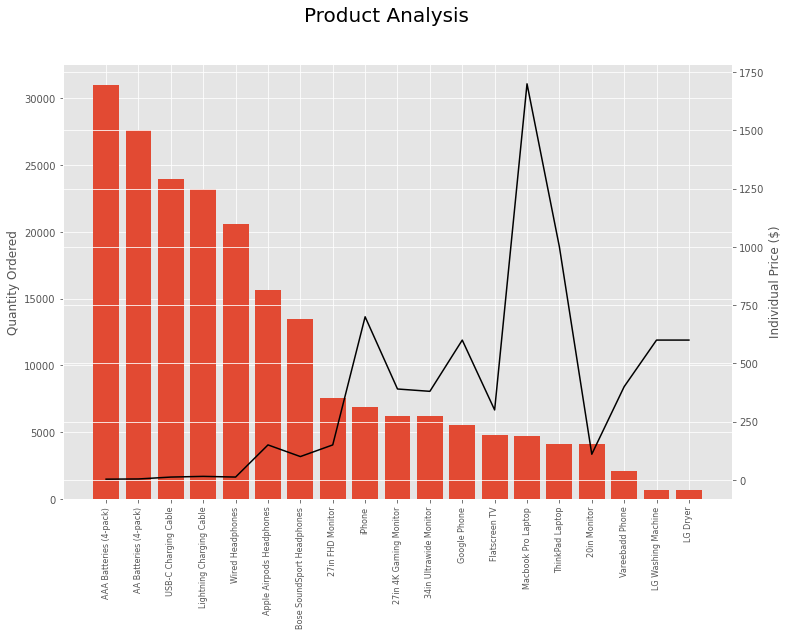

In [68]:
best_selling_products = all_data.groupby(['Product', 'Price Each'], as_index=False).agg({'Quantity Ordered': 'sum'}).sort_values('Quantity Ordered', ascending=False)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

fig.suptitle('Product Analysis', fontsize=20)

ax1.bar(best_selling_products['Product'], best_selling_products['Quantity Ordered'])
ax2.plot(best_selling_products['Product'], best_selling_products['Price Each'], 'black')

ax1.set_ylabel('Quantity Ordered')
ax2.set_ylabel('Individual Price ($)')
ax1.set_xticklabels(best_selling_products['Product'], rotation='vertical', size=8)

plt.show()

# The best-selling products are also the most cheapest, which makes sense, and the most expensive products have lower sales
# However, products like 'Macbook Pro Laptop' are not the least sold despite being the most expensive. This may be due to the fact that these are products that people want despite their price, since they are very useful and have an excellent quality.